### Fetch data

#### Load dependencies

In [17]:
# path variables
import sys
sys.path.insert(0, '/Users/sarfrazahmed/Documents/projects/deposit-model/conf')
from config import SQLQuery

# core libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, roc_auc_score
from scipy.stats import ks_2samp

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from pandas_profiling import ProfileReport
import scikitplot as skplt

# setting constants
pio.templates.default = 'plotly_dark'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_map = {'high': '#00cc96', 'low': '#636efa'}

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Fetching Data

In [4]:
querySno = SQLQuery('snowflake')
q = querySno

df_raw = q("""with 

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and Feb 2022
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
),

ALLOY_PERSONS as -- get all the alloy persons data (max of application_versions_id in case of duplicates)
(
  select * from (
select * ,
       row_number() over (partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as rank
from "PROD_DB"."DATA"."ALLOY_EVALUATIONS_PERSONS") 
where rank=1
),

APPLICATION_DETAIL as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESS_DETAIL b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 60
    group by 1,2
)

    select * 
    from base
    left join APPLICATION_DETAIL B
    on base.APPLICATION_ID = B.APPLICATION_ID""")

df_raw.shape

(110642, 102)

In [39]:
# 12 months revenue from account creation date
querySno = SQLQuery('snowflake')
q = querySno

df_raw = q("""with 

REV AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           Abs(AMOUNT)*0.0185 as REVENUE 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='debit' and status='active' and medium='POS Withdrawal'
  group by 1,2,3
),

BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and May 2022
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2021-05-31'
),


APPLICATION_DETAIL as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.REVENUE) as total_revenue
    from BUSINESS_DETAIL b 
    inner join REV t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 365
    group by 1,2
),

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

FINAL_TRANSACTIONS AS 
(
  select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.AMOUNT) as total_credit_amount
    from BUSINESS_DETAIL b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 60
    group by 1,2
 )

    select base.*,FINAL_TRANSACTIONS.total_credit_amount,APPLICATION_DETAIL.*
    from base
    inner join FINAL_TRANSACTIONS
    on base.APPLICATION_ID = FINAL_TRANSACTIONS.APPLICATION_ID
    left join APPLICATION_DETAIL
    on base.APPLICATION_ID = APPLICATION_DETAIL.APPLICATION_ID
""")

df_raw.shape

(38501, 103)

#### Add target variable

In [68]:
df = df_raw.copy(deep=True)
df['deposit_class'] = np.where(df['total_credit_amount']<800, 0, np.where(df['total_credit_amount']>1200, 1, 'mid'))
df = df[df['deposit_class'] != 'mid']
print(df['deposit_class'].value_counts())
df.shape

0    53190
1    49719
Name: deposit_class, dtype: int64


(102909, 103)

#### Derived variables

In [69]:
# Application Completion Duration
df['application_completion_duration'] = (df['application_complete_datetime'] - df['application_start_datetime']).astype('timedelta64[m]')

# Email Domain
df['email_domain_variable'] = np.where(df['email_domain'].isin(['gmail.com', 'yahoo.com', 'outlook.com', 'icloud.com', 'hotmail.com']), df['email_domain'], 'others')

# Week Number
df['week'] = df['application_start_datetime'].dt.week

# Business Age
df['date_of_establishment_dt'] = pd.to_datetime(df['date_of_establishment'], format='%Y-%m', errors='coerce').dropna()
df['business_age'] = round((df['application_start_datetime'] - df['date_of_establishment_dt']) / np.timedelta64(1, 'Y'),2)
df['business_age'] = df['business_age'].fillna(0)

# Number of Employees
df["number_of_employees"] = pd.to_numeric(df["number_of_employees"])
df['number_of_employees_bin'] = df["number_of_employees"]
df['number_of_employees_bin'] = np.where((df['number_of_employees']>=5) & (df['number_of_employees']<=10), '5-10', 
                                np.where((df['number_of_employees']>10) & (df['number_of_employees']<=20), '11-20', 
                                np.where((df['number_of_employees']>20), '20+', df['number_of_employees_bin'])))

# Website Flag
df['website_flag'] = np.where(df['website'] != df['website'], 'Offline', 'Online')

#### List dependent and independent

In [70]:
dependent_variable = ['deposit_class']
independent_variables = ['business_type',
                         'business_address_state',
                         'email_domain_variable',
                         'application_completion_duration',
                         'application_channel',
                         'estimated_monthly_revenue', 
                         'incoming_ach_payments',
                         'check_deposit_amount',
                         'incoming_wire_transfer',
                         'outgoing_ach_and_checks',
                         'outgoing_wire_transfers',
                         'business_age',
                         'industry_category_name',
                         'number_of_employees_bin',
                         'website_flag',
                         'high_risk_industry',
                         'aml_risk_score']

#### Drop null rows

In [71]:
print(df.shape)
df.dropna(subset=independent_variables, inplace=True)
print(df.shape)

(102909, 110)
(102843, 110)


#### Encode categorical variables

In [72]:
for variable in list(df[independent_variables].select_dtypes(include=['object']).columns):
    df[variable]=df[variable].astype('category').cat.codes
df[independent_variables].head()

,business_type,business_address_state,email_domain_variable,application_completion_duration,application_channel,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,business_age,industry_category_name,number_of_employees_bin,website_flag,high_risk_industry,aml_risk_score
0,1,9,0,24.0,6,2,2,2,2,2,2,0.10,16,0,1,1,221.0
1,3,4,0,13.0,0,2,2,2,0,5,0,0.00,1,0,0,0,233.0
2,3,45,2,30.0,4,2,5,5,5,5,5,0.00,16,0,0,0,215.0
3,1,3,0,15.0,0,3,4,4,4,4,4,0.26,6,6,0,0,205.0
4,3,4,0,12.0,6,2,2,5,0,2,0,0.00,16,0,1,0,231.0


#### Train test split

In [79]:
X = df[independent_variables]
y = df[dependent_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(82274, 17)
(20569, 17)
(82274, 1)
(20569, 1)


#### XGBoost Fit

In [80]:
model = XGBClassifier()
model.fit(X_train[independent_variables], y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[16:26:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Train Report

In [81]:
y_pred = model.predict(X_train[independent_variables].values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_train, y_pred, labels=['1', '0']), 
    index=['true:1', 'true:0'], 
    columns=['pred:1', 'pred:0']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_train, y_pred), '\n')

# Classification Report
print(classification_report(y_train, y_pred))

        pred:1  pred:0
true:1   26872   12900
true:0   11795   30707 

Accuracy Score: 0.6998444222962297 

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     42502
           1       0.69      0.68      0.69     39772

    accuracy                           0.70     82274
   macro avg       0.70      0.70      0.70     82274
weighted avg       0.70      0.70      0.70     82274



#### Test Scores

In [82]:
y_pred = model.predict(X_test[independent_variables].values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=['1', '0']), 
    index=['true:1', 'true:0'], 
    columns=['pred:1', 'pred:0']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_test, y_pred), '\n')

# Classification Report
print(classification_report(y_test, y_pred))

        pred:1  pred:0
true:1    6011    3899
true:0    3675    6984 

Accuracy Score: 0.6317759735524333 

              precision    recall  f1-score   support

           0       0.64      0.66      0.65     10659
           1       0.62      0.61      0.61      9910

    accuracy                           0.63     20569
   macro avg       0.63      0.63      0.63     20569
weighted avg       0.63      0.63      0.63     20569



#### Model Metrics Function

In [14]:
y_true = y_test.values.flatten().astype(int)
y_pred = y_pred.astype(int)
predicted_probas = model.predict_proba(X_test)

In [104]:
type(model)

xgboost.sklearn.XGBClassifier

In [109]:
def model_metrics(model, y_pred, y_true, y_prob):
    '''
    Returns the evaluation metrics for a binary classification model

        Parameters:
                model (object): a binary classifier model object
                y_pred (array(int)): array of predicted labels consisting of only 0 and 1
                y_true (array(int)): array of actual labels consisting of only 0 and 1
                y_prob (array(int)): 2 dimensional array of predicted probabilities
        
        Returns:
                accuracy score (int): accuracy score of the binary classifier
                confusion matrix (int): confusion matrix of the binary classifier
                fpr (int): false positive rate of the binary classifier
                tpr (int): true positive rate of the binary classifier
                auc (int): area under curve score for the binary classifier
                sensitivity (int): sensitivity of the binary classifier
                specificity (int): specificity of the binary classifier
                f1-score (int): f1-score of the binary classifier
                ks-score (int): KS score of the binary classifier
                classification report (int): elaborate precision recall report of the binary classifier
                gain chart (plot): gain chart plot of the binary classifier
                lift chart (plot): lift chart plot of the binary classifier
                
        Raises:
                ValueError: If length of y_pred is not equal to length of y_true or X_test
    '''

    # Check if arrays are of different length
    if len(y_pred) != len(y_true):
        raise ValueError('Length of y_pred and y_true is not matching')

    # Check if arrays are of different length
    if len(y_pred) != len(y_prob):
        raise ValueError('Length of y_pred and y_prob is not matching')

    # Accuracy Score
    print('Accuracy Score:', np.round(accuracy_score(y_true, y_pred), 2), '\n')

    # Confusion Matrix
    cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=[1, 0]), 
    index=['true:1', 'true:0'], 
    columns=['pred:1', 'pred:0'])
    print('Confusion Matrix:')
    print(cmtx, '\n')

    # FPR, TPR, AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print('FPR:', np.round(fpr[1],2))
    print('TPR:', np.round(tpr[1],2))
    print('AUC:', np.round(auc(fpr, tpr), 2), '\n')

    # Sensitivity, Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('Sensitivity:', np.round(tp/(tp+fn),2))
    print('Specificity:', np.round(tn/(tn+fp),2), '\n')

    # F1 Score
    print('F1 Score:', np.round(f1_score(y_true, y_pred), 2), '\n')

    # KS Statistic
    print('KS Score:')
    print(ks_2samp(y_pred, y_true), '\n')
    
    # Classification Report
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    # Gain chart
    print('Gain Chart')
    skplt.metrics.plot_cumulative_gain(y_true, predicted_probas, figsize=(10, 6), title_fontsize=18, text_fontsize=16)
    plt.show()

    # Lift chart
    print('Lift Chart')
    skplt.metrics.plot_lift_curve(y_true, predicted_probas, figsize=(10, 6), title_fontsize=18, text_fontsize=16)
    plt.show()

Accuracy Score: 0.63 

Confusion Matrix:
        pred:1  pred:0
true:1    6011    3899
true:0    3675    6984 

FPR: 0.34
TPR: 0.61
AUC: 0.63 

Sensitivity: 0.61
Specificity: 0.66 

F1 Score: 0.61 

KS Score:
KstestResult(statistic=0.01089017453449359, pvalue=0.17307084967705744) 

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     10659
           1       0.62      0.61      0.61      9910

    accuracy                           0.63     20569
   macro avg       0.63      0.63      0.63     20569
weighted avg       0.63      0.63      0.63     20569

Gain Chart


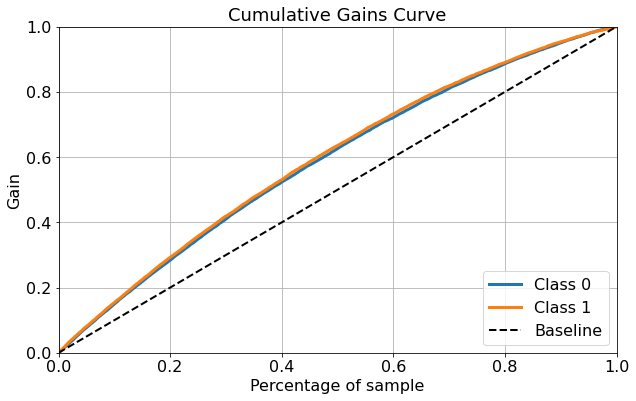

Lift Chart


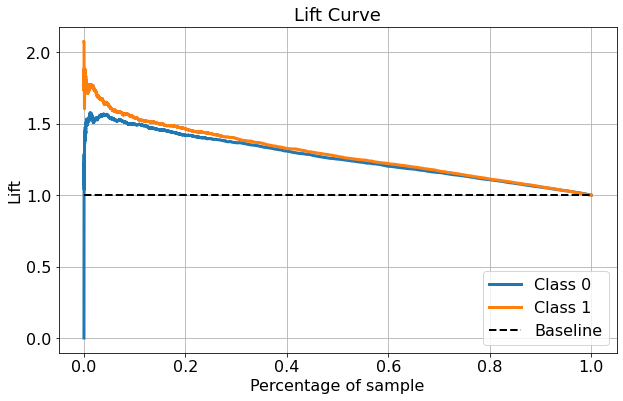

In [113]:
model_metrics(model, y_pred, y_true, predicted_probas)